In [ ]:
# Copyright (C) 2024  Jose Ángel Pérez Garrido
# 
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

# 2. Data Preprocessing

## Dataset description

We will use the [CelebA Dataset](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset). This dataset is great for training and testing models for face detection, particularly for recognising facial attributes such as finding people with brown hair, are smiling, or wearing glasses, or face generation as for our problem. Images cover large pose variations, background clutter, diverse people, supported by a large quantity of images and rich annotations. This data was originally collected by researchers at MMLAB, The Chinese University of Hong Kong. It is composed by **202,599** number of face images of various celebrities.


### Prepare the environment

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import glob
import numpy as np
import matplotlib.pyplot as plt
#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from keras import utils

In [2]:
def display(images, dom=[-1,1], size=(20, 3), cmap="viridis", as_type="float32", save_to=None):
    """
    Display images horizontally.

    Args:
        images (numpy.ndarray): The images to display.
        dom (list): The domain of pixel values (default is [-1,1]).
        size (tuple): The figure size (default is (20, 3)).
        cmap (str): The colormap (default is "viridis").
        as_type (str): The data type to cast the images to (default is "float32").
        save_to (str): The file path to save the plot (default is None).
    """
    # Ensure range is correct
    if images.min() < dom[0]:
      dom[0] = images.min()
    if images.max() > dom[1]:
      dom[1] = images.max()

    # Normalize
    if dom != [0,1]:
      images = (images-dom[0]) / (dom[1]-dom[0])

    # Verify
    assert images.max() <= 1.0, f"Found pixel value higher than {dom[1]}.0! - {images.max()}"
    assert images.min() >= 0.0, f"Found pixel value lower than {dom[0]}.0! - {images.min()}"

    # Plot
    plt.figure(figsize=size)
    for i in range(images.shape[0]):
        _ = plt.subplot(1, images.shape[0], i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    # Save
    if save_to:
        dir = os.path.dirname(save_to)
        if not os.path.exists(dir):
          os.mkdir(dir)
        plt.savefig(os.path.abspath(save_to))

    plt.show()

Next, we will load the dataset (data flows). VAEs and GANs have different requirements for training data format, so we divide the **Data preprocessing** steps in two sections.

In the **GAN** preprocessing method, the target output class mode is not specified, as GANs typically do not have a specific target output. Instead, the focus is on preparing the input images for training the generator and discriminator networks. However, in the **VAE** preprocessing method, the input images are also the target outputs for training the VAE model. This setting is common for autoencoder architectures, including VAEs, where the model aims to reconstruct the input data.

We also define parameters related to image loading such as `IMAGE_SIZE` (dimensions of the input images (square aspect ratio), e.g. 128 -> (128x128)), `CHANNELS` (number of color channels) and `BATCH_SIZE` (number of images processed in each training iteration).

### Load dataset

In [3]:
# Get dataset .jpg images
DATA_FOLDER = "./datasets/img_align_celeba/"
filenames = np.array(glob.glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 202599


### Data preprocessing for VAE

Firstly, the `ImageDataGenerator` is initialized to rescale the pixel values of the input images to the range [0, 1] by dividing them by 255, ensuring that the pixel values are in a suitable range for neural network training. Next, the `flow_from_directory` method is used to generate batches of images from the specified **DATA_FOLDER**, with parameters set to configure the dataset such as target size, batch size, shuffling, class mode, color mode, and interpolation method. The generated batches consist of RGB images with dimensions specified by IMAGE_SIZE, and the class mode is set to 'input', indicating that the input images are also the target outputs.

In [4]:
# Constants
IMAGE_SIZE = 32
CHANNELS = 3
BATCH_SIZE = 64

# Generator that creates batches of rgb images in the range [0,1]
data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(
    DATA_FOLDER, 
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='input', 
    color_mode='rgb',
    interpolation='bilinear'
)

Found 202599 images belonging to 1 classes.


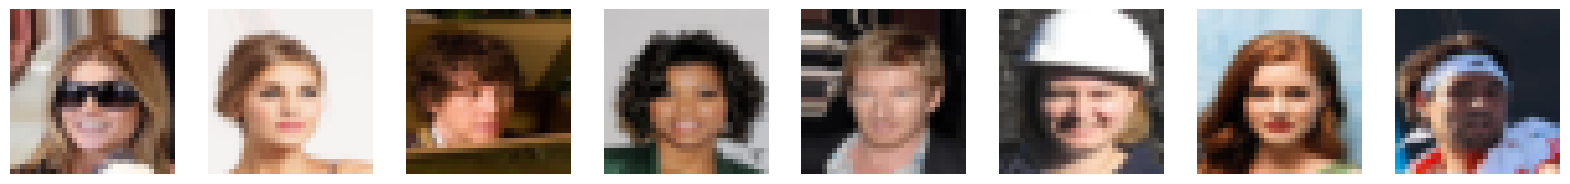

In [6]:
data_samples_examples = next(data_flow)[0][:8]
display(data_samples_examples, dom=[0,1], cmap='viridis')

### Data preprocessing for GAN

Firstly, we normalize the pixel values of the input images to the range [-1, 1] (as indicated in [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks?tab=readme-ov-file#1-normalize-the-inputs)) by scaling the pixel values by 127.5 and subtracting 127.5. This normalization facilitates training stability and helps the generator and discriminator networks to converge effectively. Secondly, we reshape the images to a consistent size specified by **IMAGE_SIZE**. The dataset is then loaded from the directory specified by **DATA_FOLDER**, using TensorFlow's `image_dataset_from_directory` utility, with parameters set to configure the dataset such as color mode, image size, batch size, shuffling, and interpolation method. Finally, the dataset is repeated to ensure an adequate number of samples for each epoch of training, based on the specified **BATCH_SIZE, STEPS_PER_EPOCH**, and **EPOCHS**.

In [7]:
# Constants
IMAGE_SIZE = 32
BATCH_SIZE = 64
EPOCHS = 50
STEPS_PER_EPOCH = 1500

# Preprocess the data
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img
    
# Load the data
train_data = utils.image_dataset_from_directory(
    DATA_FOLDER,
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
).map(lambda x: preprocess(x))


# Repeat the dataset so we have enough samples for all the epochs
samples_per_epoch = BATCH_SIZE * STEPS_PER_EPOCH
total_samples = samples_per_epoch * EPOCHS
n_repetitions = int(total_samples / 202599)
train_data = train_data.repeat(n_repetitions)

Found 202599 files belonging to 1 classes.


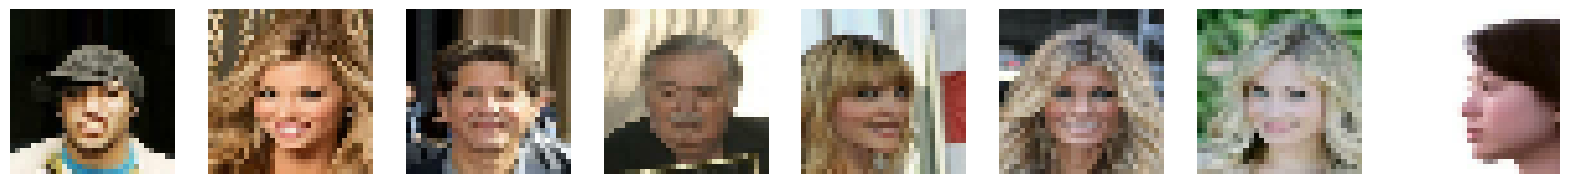

In [8]:
display(next(train_data.as_numpy_iterator())[:8])

At this time we have correctly loaded and preprocessed the training data for training both VAEs and GANs. This step has been subdivided in two Notebooks (3.1. Training Comparisons and Evaluations VAES and 3.2. Training Comparisons and Evaluations GANS) for the sake of clarity. Notice that the preprocessing steps shown above will be also carry out in their respective model training notebook.